In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from sklearn.decomposition import PCA
import pickle

/home/ziweiji/miniconda3/envs/detect/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# merge all dataset

In [3]:
models_all_Hs_l_2d, models_n_uncertain = {}, {}
DATASETS = {'trivia_qa': 'TriviaQA', 'nq_open': 'NQ-open', 'pop_qa': 'PopQA'}

In [4]:
# N = 5000
N = -1
prompt_type = 'sentence'
# prompt_type = 'uncertainty'
# model_name = 'Meta-Llama-3.1-8B-Instruct'
# model_name = 'Mistral-7B-Instruct-v0.3'
# model_name = 'Qwen2.5-7B-Instruct'
model_name = 'llama-3.1-8B-grpo'
all_Hs_questions_uncertain_ling, all_Hs_questions_certain_ling = [], []
all_lu_scores_llm_uncertain, all_lu_scores_llm_certain = [], []
for dataset in ['trivia_qa', 'pop_qa', 'nq_open']:
    for split in ['val', 'test', 'train']:
        out_dir = f'./outputs/{dataset}/{model_name}/{prompt_type}/{split}'
        Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
        Hs_questions_certain_ling = torch.load(f'{out_dir}/certain_ling.pt')
        print(Hs_questions_certain_ling.shape)
        all_Hs_questions_uncertain_ling.append(Hs_questions_uncertain_ling)
        all_Hs_questions_certain_ling.append(Hs_questions_certain_ling)
        if model_name == 'Meta-Llama-3.1-8B-Instruct':
            results_df = pd.read_csv(f"../datasets/{dataset}/sampled/{split}.csv")
        else:
            results_df = pd.read_csv(f"../datasets/{dataset}/{model_name}/{split}.csv")
        lu_scores_llm = results_df['ling_uncertainty'].to_numpy()
        per_all_lu_scores_llm_uncertain = [lu_scores_llm[i] for i in range(len(results_df)) if lu_scores_llm[i] >= 0.9]
        all_lu_scores_llm_uncertain += per_all_lu_scores_llm_uncertain
        per_all_lu_scores_llm_certain = [lu_scores_llm[i] for i in range(len(results_df)) if lu_scores_llm[i] <= 0.05]
        all_lu_scores_llm_certain += per_all_lu_scores_llm_certain
        print(len(per_all_lu_scores_llm_uncertain), len(per_all_lu_scores_llm_certain))
        print(Hs_questions_uncertain_ling.shape, Hs_questions_certain_ling.shape)
        assert len(per_all_lu_scores_llm_uncertain) == Hs_questions_uncertain_ling.shape[0]
        assert len(per_all_lu_scores_llm_certain) == Hs_questions_certain_ling.shape[0]

all_Hs_questions_uncertain_ling = torch.concat(all_Hs_questions_uncertain_ling, dim=0)
all_Hs_questions_certain_ling = torch.concat(all_Hs_questions_certain_ling, dim=0)
print(all_Hs_questions_uncertain_ling.shape)
print(all_Hs_questions_certain_ling.shape)

if N > 0:
    ling_uncertain_idx = np.argsort(all_lu_scores_llm_uncertain)[-N:]
    ling_certain_idx = np.argsort(all_lu_scores_llm_certain)[:N]
    all_Hs_questions_uncertain_ling = all_Hs_questions_uncertain_ling[ling_uncertain_idx]
    all_Hs_questions_certain_ling = all_Hs_questions_certain_ling[ling_certain_idx]

Hs_hedge_kuq = all_Hs_questions_uncertain_ling.mean(0) - all_Hs_questions_certain_ling.mean(0)

os.makedirs(f'outputs/merged/{model_name}/{prompt_type}', exist_ok=True)
torch.save(Hs_hedge_kuq, f'outputs/merged/{model_name}/{prompt_type}/Hs_hedge_universal.pt')

/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([333, 32, 4096])
23 333
torch.Size([23, 32, 4096]) torch.Size([333, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([334, 32, 4096])
31 334
torch.Size([31, 32, 4096]) torch.Size([334, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([3248, 32, 4096])
289 3248
torch.Size([289, 32, 4096]) torch.Size([3248, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([92, 32, 4096])
186 92
torch.Size([186, 32, 4096]) torch.Size([92, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([101, 32, 4096])
193 101
torch.Size([193, 32, 4096]) torch.Size([101, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_certain_ling = torch.load(f'{out_dir}/certain_ling.pt')


torch.Size([1107, 32, 4096])
1788 1107
torch.Size([1788, 32, 4096]) torch.Size([1107, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([283, 32, 4096])
40 283
torch.Size([40, 32, 4096]) torch.Size([283, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([283, 32, 4096])
43 283
torch.Size([43, 32, 4096]) torch.Size([283, 32, 4096])


/tmp/ipykernel_1178260/387711579.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Hs_questions_uncertain_ling = torch.load(f'{out_dir}/uncertain_ling.pt')
/tmp/ipykernel

torch.Size([2662, 32, 4096])
447 2662
torch.Size([447, 32, 4096]) torch.Size([2662, 32, 4096])
torch.Size([3040, 32, 4096])
torch.Size([8443, 32, 4096])


In [4]:
# model_name = 'Meta-Llama-3.1-8B-Instruct'
# prompt_type = 'sentence'
# Hs_hedge_kuq = torch.load(f'outputs/merged/{model_name}/{prompt_type}/Hs_hedge_universal.pt')

all_Hs_l_2d = {}
 
for l in tqdm(range(Hs_hedge_kuq.shape[0])):
    Hs_l = torch.cat([all_Hs_questions_uncertain_ling[:,l], all_Hs_questions_certain_ling[:,l]]).numpy()
    Hs_l_2d = PCA(n_components=2).fit_transform(Hs_l)
    all_Hs_l_2d[l] = Hs_l_2d

n_uncertain = all_Hs_questions_uncertain_ling.shape[0]

models_all_Hs_l_2d[model_name] = all_Hs_l_2d
models_n_uncertain[model_name] = n_uncertain

# with open(f'outputs/merged/{model_name}/{prompt_type}/all_Hs_l_2d.pkl', 'wb') as f:
#     pickle.dump(all_Hs_l_2d, f)
#     pickle.dump(n_uncertain, f)

100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


In [7]:
f'outputs/merged/{model_name}/{prompt_type}/all_Hs_l_2d.png'

'outputs/merged/llama-3.1-8B-grpo/uncertainty/all_Hs_l_2d.png'

100%|██████████| 32/32 [00:00<00:00, 407.08it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/opt/hpcaas/.mounts/fs-0df31b178aa4037ac/home/ziweiji/Hallu_Det/calibration/outputs/merged/llama-3.1-8B-grpo/uncertainty/all_Hs_l_2d.png'

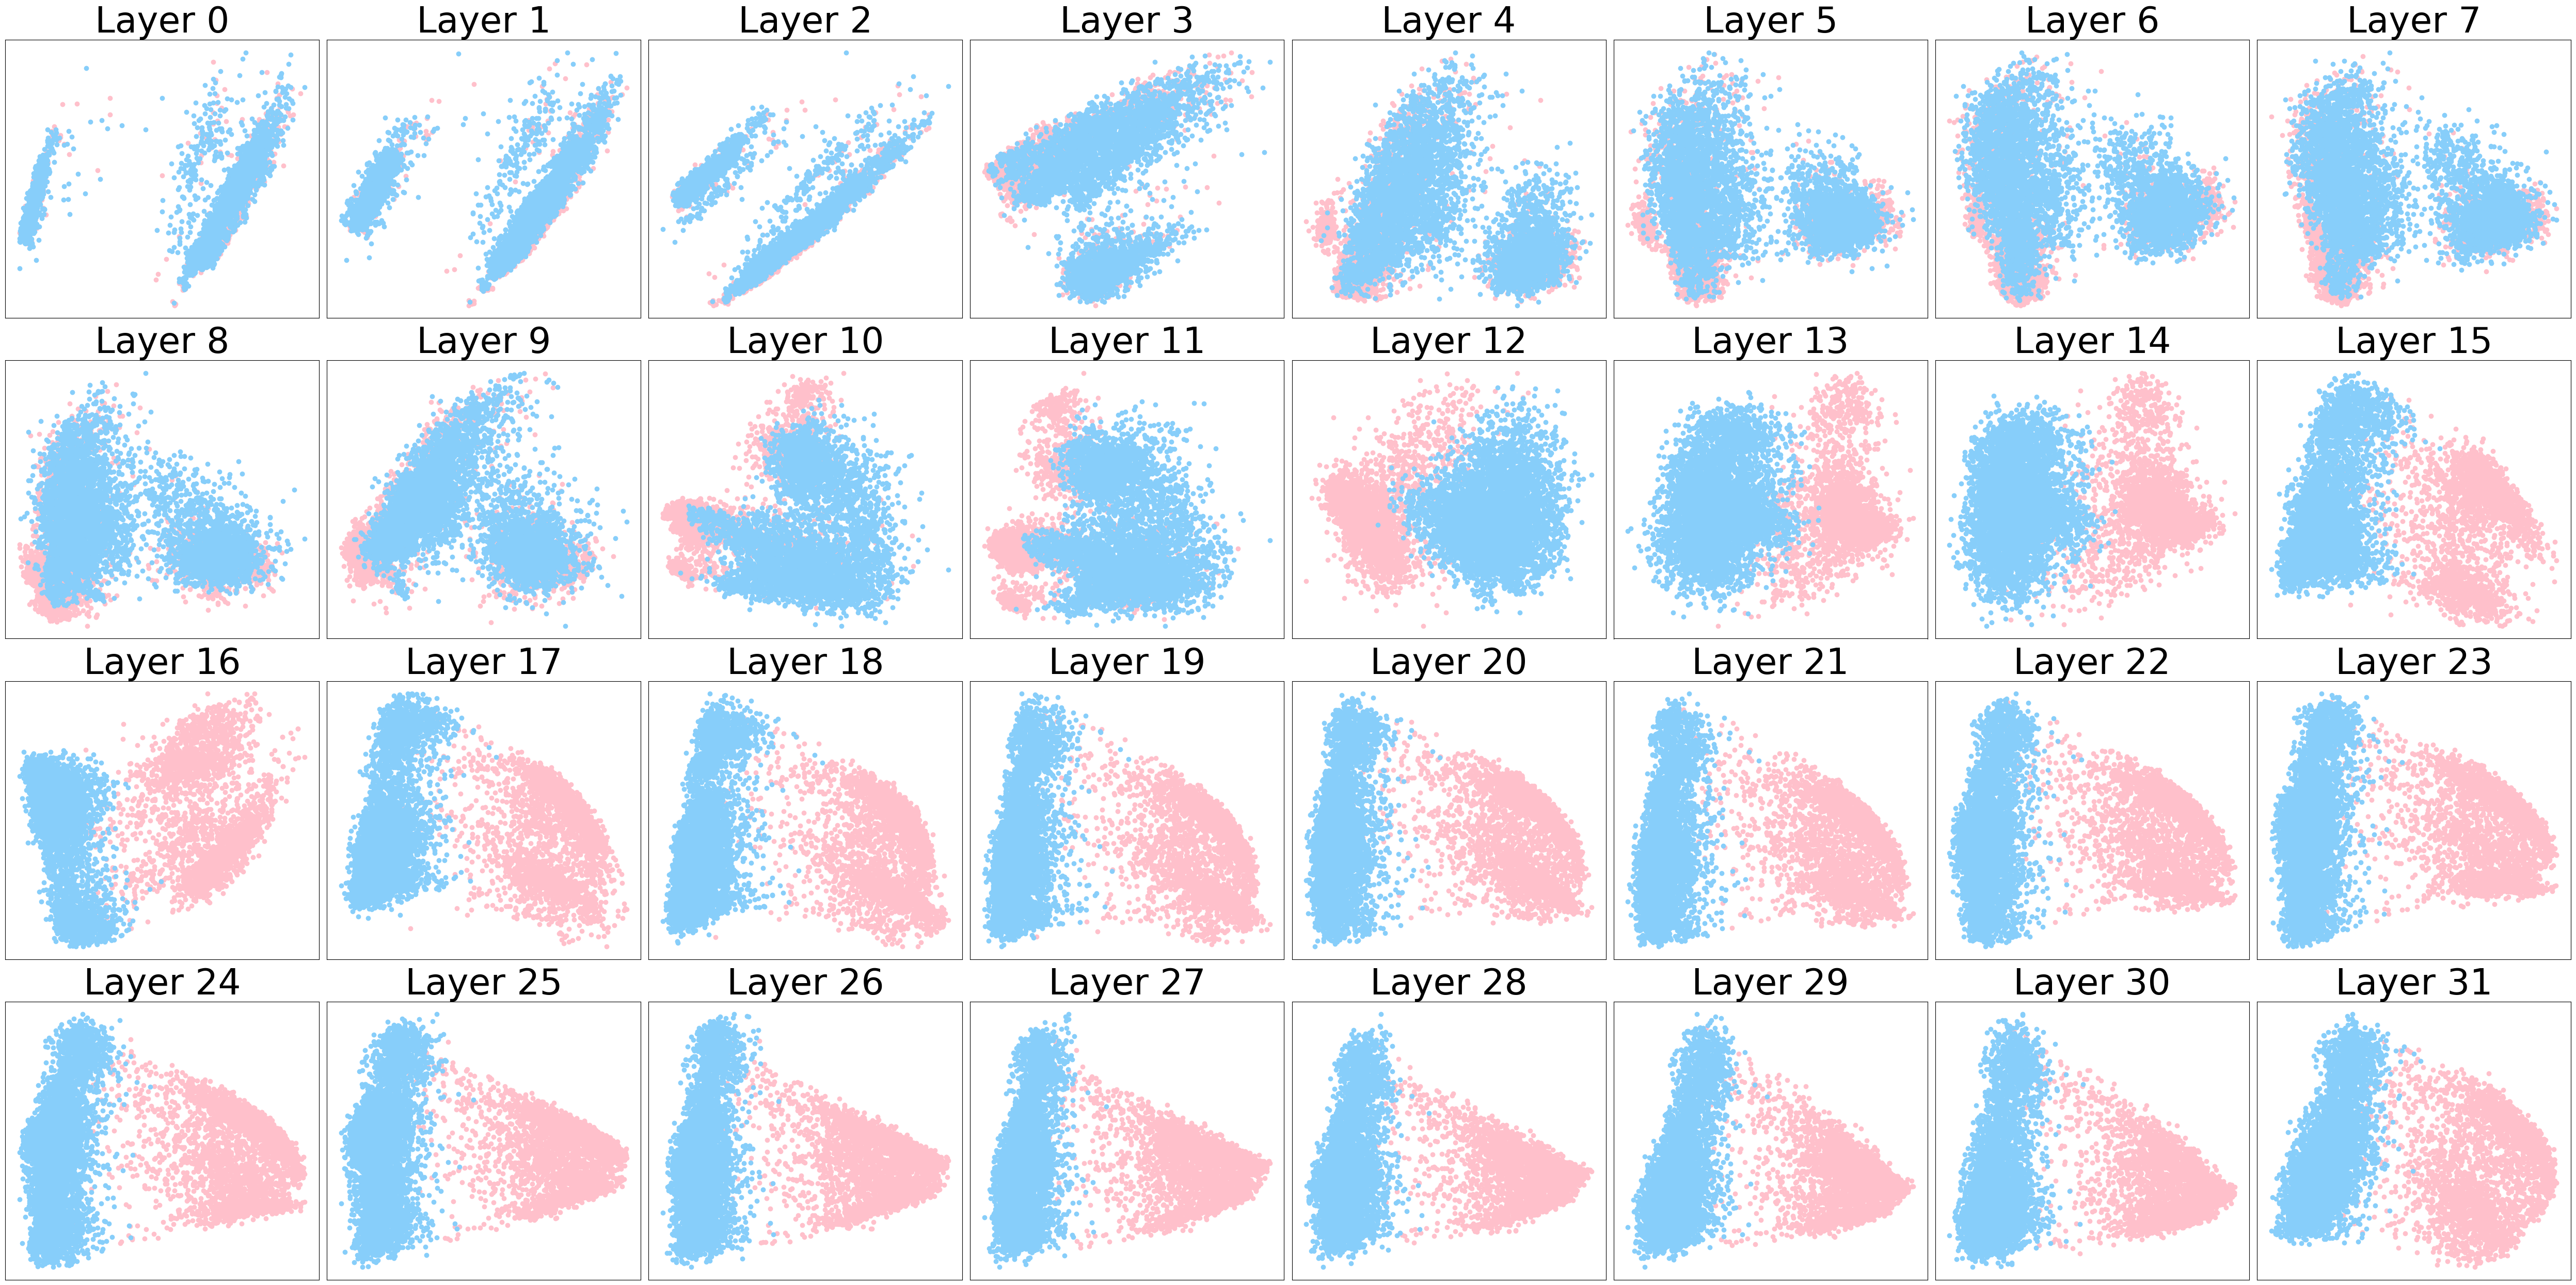

In [5]:
# all datasets
if model_name == 'Qwen2.5-7B-Instruct':
    fig, ax = plt.subplots(4, 7, figsize=(50, 25))
else:
    fig, ax = plt.subplots(4, 8, figsize=(50, 25))

for l in tqdm(range(Hs_hedge_kuq.shape[0])):
    if model_name == 'Qwen2.5-7B-Instruct':
        i, j = l // 7, l % 7
    else:
        i, j = l // 8, l % 8
        

    Hs_l_2d = all_Hs_l_2d[l]
    ax[i][j].scatter(Hs_l_2d[:n_uncertain, 0], Hs_l_2d[:n_uncertain, 1], label='ling-uncertain', color='pink')
    ax[i][j].scatter(Hs_l_2d[n_uncertain:, 0], Hs_l_2d[n_uncertain:, 1], label='ling-certain', color='lightskyblue')
    ax[i][j].set_title(f"Layer {l}", fontsize=50)

    # without x label and y label
    ax[i][j].set_xlabel('')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    if l == 0:
        handles, labels = ax[i][j].get_legend_handles_labels()
    
# fig.legend(handles, labels, loc='upper right', fontsize='large')
plt.tight_layout()
# save plt
plt.savefig(f'outputs/merged/{model_name}/{prompt_type}/all_Hs_l_2d.png')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Text(0.5, 0.35, '(c) Qwen2.5-7B-Instruct')

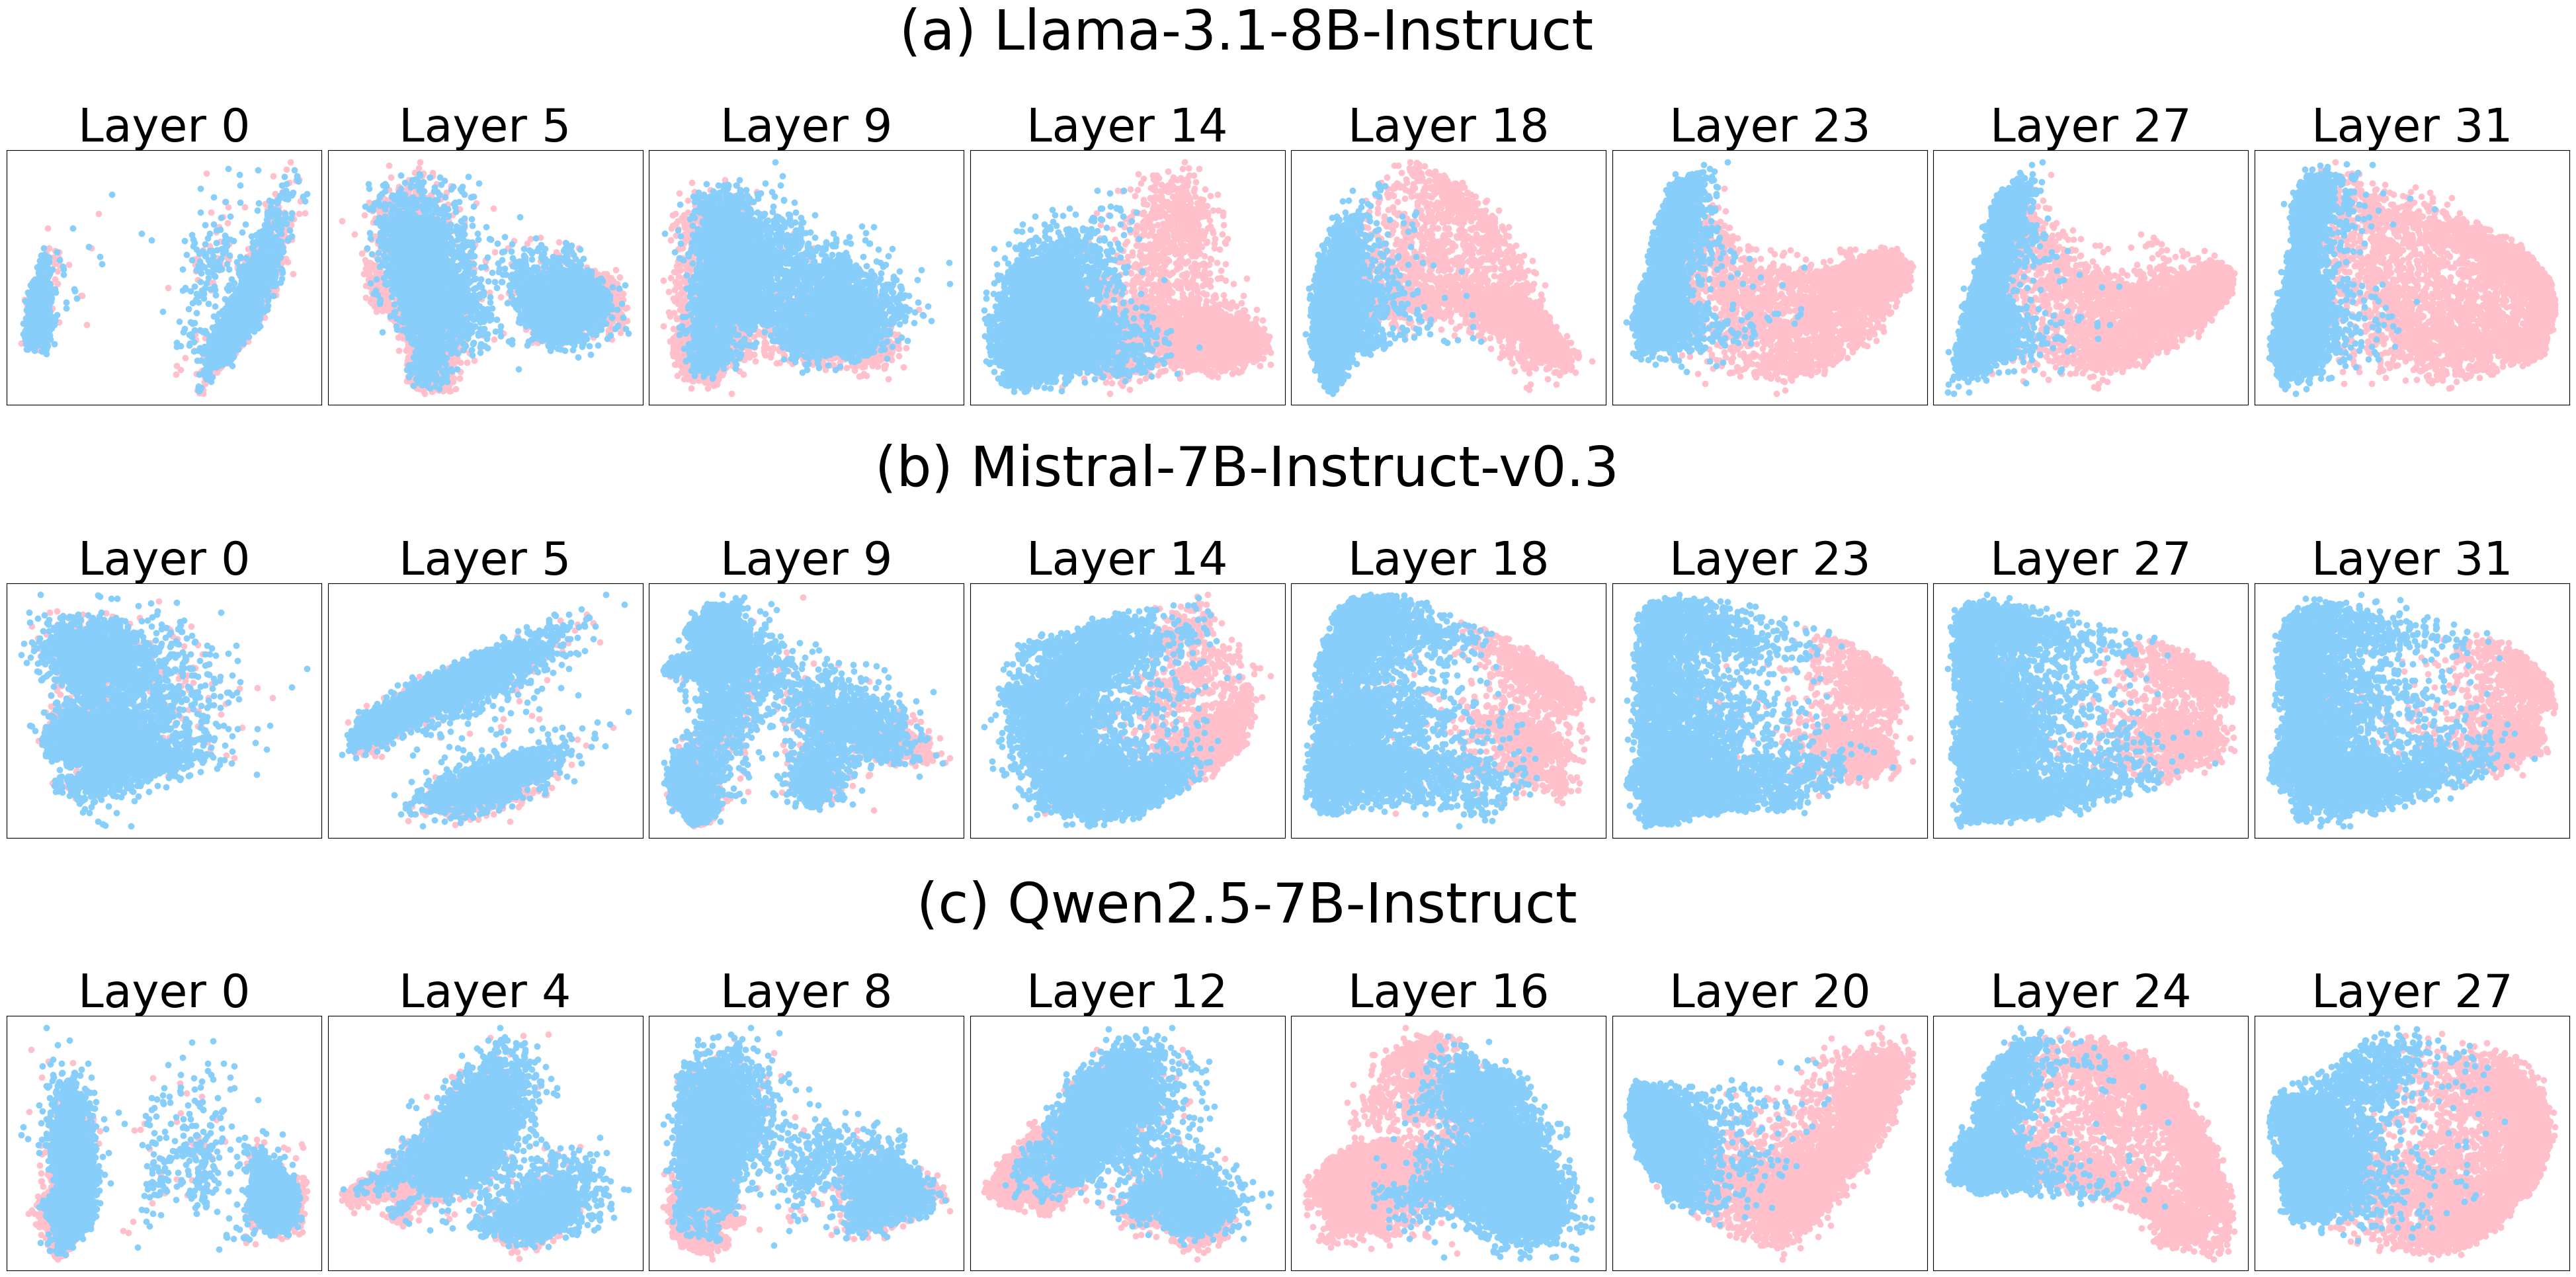

In [13]:
# selected
fig, ax = plt.subplots(3, 8, figsize=(50, 22))
fig.subplots_adjust(hspace=0.7, wspace=0.02)

for i, model_name in enumerate(['Meta-Llama-3.1-8B-Instruct', 'Mistral-7B-Instruct-v0.3', 'Qwen2.5-7B-Instruct']):
    # model 
    if model_name == 'Qwen2.5-7B-Instruct':
        layers = [0, 4, 8, 12, 16, 20, 24, 27]
    else:
        layers = [0, 5, 9, 14, 18, 23, 27, 31]
    for j, l in tqdm(enumerate(layers)):
        # print('l', l, 'j', j)
        
        all_Hs_l_2d = models_all_Hs_l_2d[model_name]
        n_uncertain = models_n_uncertain[model_name]
        
        Hs_l_2d = all_Hs_l_2d[l]
        ax[i][j].scatter(Hs_l_2d[:n_uncertain, 0], Hs_l_2d[:n_uncertain, 1], label='ling-uncertain', color='pink')
        ax[i][j].scatter(Hs_l_2d[n_uncertain:, 0], Hs_l_2d[n_uncertain:, 1], label='ling-certain', color='lightskyblue')
        ax[i][j].set_title(f"Layer {l}", fontsize=50)

        # without x label and y label
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        if l == 0:
            handles, labels = ax[i][j].get_legend_handles_labels()
fig.text(0.5, 0.95, "(a) Llama-3.1-8B-Instruct", ha='center', fontsize=60)
fig.text(0.5, 0.65, "(b) Mistral-7B-Instruct-v0.3", ha='center', fontsize=60)
fig.text(0.5, 0.35, "(c) Qwen2.5-7B-Instruct",  ha='center', fontsize=60)
# fig.legend(handles, labels, loc='upper right', fontsize='large')
# plt.tight_layout()

In [36]:
def select_layers(total_layers, N):
    interval = total_layers / (N + 1)
    return [round(interval * i) for i in range(1, N + 1)]

# Example usage:
model_A_layers = select_layers(32, 6)  # [6, 12, 18, 24]
model_B_layers = select_layers(28, 6)  # [5, 11, 17, 23]

print("Model A selected layers:", model_A_layers)
print("Model B selected layers:", model_B_layers)

Model A selected layers: [5, 9, 14, 18, 23, 27]
Model B selected layers: [4, 8, 12, 16, 20, 24]


/tmp/ipykernel_3047067/2110403604.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_LU_features[model_name][dataset] = torch.load(f'outputs/{dataset}/{model_name}/{pro

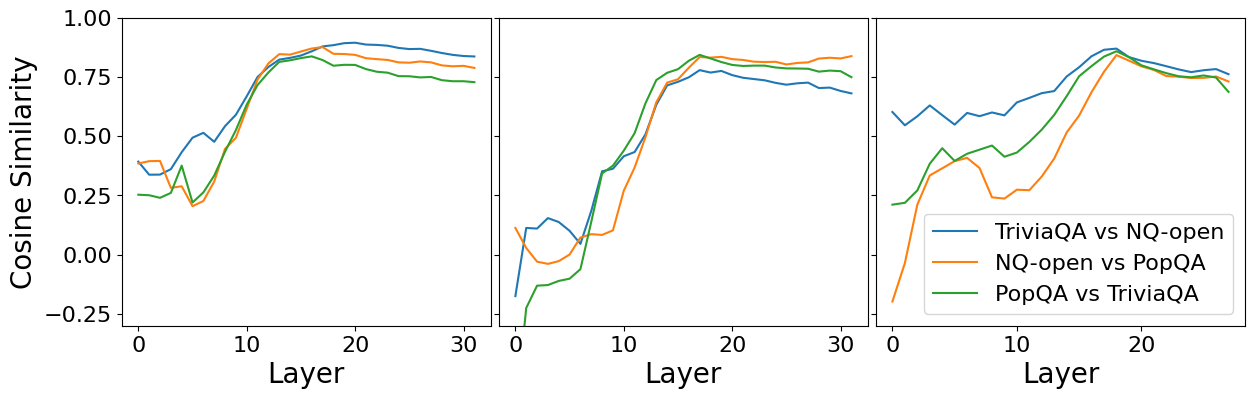

In [69]:
model_names = ['Meta-Llama-3.1-8B-Instruct', 'Mistral-7B-Instruct-v0.3', 'Qwen2.5-7B-Instruct']
DATASETS = {'trivia_qa': 'TriviaQA', 'nq_open': 'NQ-open', 'pop_qa': 'PopQA'}
from collections import defaultdict
all_LU_features = defaultdict(dict)
datasets = ['trivia_qa', 'nq_open', 'pop_qa']
for model_i, model_name in enumerate(model_names):
    for dataset in datasets:
        all_LU_features[model_name][dataset] = torch.load(f'outputs/{dataset}/{model_name}/{prompt_type}/train/Hs_hedge_universal.pt')

fig, ax = plt.subplots(1,3, figsize=(14.5,4), sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.02)
for model_i, model_name in enumerate(model_names):
    for i in range(3):
        dataset1 = datasets[i]
        dataset2 = datasets[(i+1)%3]
        cosine_sims = torch.nn.functional.cosine_similarity(all_LU_features[model_name][dataset1], all_LU_features[model_name][dataset2])
        # plt.plot(cosine_sims, label=f'{DATASETS[dataset1]} vs {DATASETS[dataset2]}')
        ax[model_i].plot(cosine_sims, label=f'{DATASETS[dataset1]} vs {DATASETS[dataset2]}')
    ax[model_i].set_xlabel('Layer', fontsize=20)
    # fontsize of x
    ax[model_i].tick_params(axis='x', labelsize=16)
    # set y limit
    ax[model_i].set_ylim([-0.3, 1.0])
    # fontsize of y
    ax[model_i].tick_params(axis='y', labelsize=16)
    # show legend
    if model_i == 2:
        # backgroundcolor transparent
        
        legend = ax[model_i].legend(fontsize=16, bbox_to_anchor=(0.1, 0.4))
    if model_i == 0:
        ax[model_i].set_ylabel('Cosine Similarity', fontsize=20)

    # plt.legend()

In [3]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import argparse
import sys
import os

/home/ziweiji/miniconda3/envs/detect/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
# 'AlistairPullen/llama-3.1-8B-grpo'
model = AutoModelForCausalLM.from_pretrained(
        model_name, torch_dtype=torch.float16, device_map='auto'
)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

: 

In [ ]:
messages = [
                {"role": "user", "content": "hello"},
            ]
inputs = tokenizer.apply_chat_template(
    messages, tokenize=True, add_generation_prompt=True, 
    return_tensors="pt", return_dict=True
)

with torch.no_grad():
    Hs_i = model(**inputs, output_hidden_states=True).hidden_states

In [6]:
Hs_i

(tensor([[[ 2.6512e-04, -4.9973e-04, -5.8365e-04,  ...,  3.8147e-03,
            6.3419e-05,  1.1902e-03],
          [-1.6499e-04, -2.4319e-04,  1.6403e-04,  ..., -1.5163e-04,
            3.5095e-04,  7.3242e-04],
          [ 8.1787e-03,  2.5749e-04, -3.4637e-03,  ...,  5.3024e-04,
            5.6152e-03,  1.6113e-02],
          ...,
          [-9.7656e-03, -3.4637e-03,  1.8616e-03,  ..., -7.1411e-03,
           -4.3030e-03,  8.6060e-03],
          [-4.6158e-04, -3.9291e-04, -6.5565e-06,  ..., -6.2561e-04,
           -5.0354e-04,  6.6757e-04],
          [-2.8687e-03,  3.8910e-03, -1.7357e-04,  ...,  8.0872e-04,
            5.0354e-04,  2.3041e-03]]], dtype=torch.float16),
 tensor([[[ 0.0022,  0.0041, -0.0007,  ...,  0.0190, -0.0042, -0.0026],
          [ 0.0032,  0.0237,  0.0121,  ...,  0.0091, -0.0523, -0.0050],
          [-0.0017, -0.0217, -0.0102,  ...,  0.0075, -0.0154,  0.0022],
          ...,
          [-0.0248, -0.0296,  0.0009,  ..., -0.0231,  0.0128, -0.0010],
          [ 0.01